# CS579: Assignment 1
## Collecting a political social network

In this assignment, I've given you a list of Twitter accounts of 15 U.S. presedential candidates.
The goal is to use the Twitter API to construct a social network of these accounts. We will then use the [networkx](http://networkx.github.io/) library to plot these links, as well as print some statistics of the resulting graph.

1. Copy the files from this directory into the `asg/a1` folder of your private repository.
2. Create an account on [twitter.com](http://twitter.com).
3. Generate authentication tokens by following the instructions [here](https://dev.twitter.com/docs/auth/tokens-devtwittercom).
4. Add your tokens to the `twitter.cfg` file. (API Key == Consumer Key)
5. Be sure you've installed the Python modules [networkx](http://networkx.github.io/) and [TwitterAPI](https://github.com/geduldig/TwitterAPI). Assuming you've already installed [pip](http://pip.readthedocs.org/en/latest/installing.html), you can do this with `pip install networkx TwitterAPI`.

OK, now you're ready to start collecting some data!

I've provided a partial implementation below. Your job is to complete the code where indicated.  
You only need to modify the 6 methods indicated by **#TODO**

Your output should match the samples provided below.

In [1]:
# Imports you'll need.
from collections import Counter
import ConfigParser
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
from TwitterAPI import TwitterAPI

%matplotlib inline

In [2]:
# This method is done for you. Make sure to put your credentials in twitter.cfg.
def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = ConfigParser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
print('Established Twitter connection.')

Established Twitter connection.


In [3]:
def read_candidates(filename):
    """ Read a list of usernames for U.S. presedential candidates
    Args:
      filename: The name of the text file containing in format:
         <twitter handle> <R or D for Republican or Democrat>
    Returns:
      A list of (string, string) tuples representing each (handle, party) pair.
    """
    # TODO
    candidates = []
    with open(filename, 'r') as fp:             # Used 'with' keyword to close files safely
      for line in fp:                           # Iterating over each line in file
        line = line.rstrip()                    # Removed the \n at the end of the line
        candidates.append(tuple(line.split()))  # Split the string into a list of tuples
    return candidates
        
        
candidates = read_candidates('candidates.txt')
print('Read %d candidates' % len(candidates))
print('\n'.join(str(x) for x in candidates))

Read 15 candidates
('HillaryClinton', 'D')
('BernieSanders', 'D')
('MartinOMalley', 'D')
('JoeBiden', 'D')
('JimWebbUSA', 'D')
('realDonaldTrump', 'R')
('JebBush', 'R')
('RealBenCarson', 'R')
('marcorubio', 'R')
('ScottWalker', 'R')
('tedcruz', 'R')
('CarlyFiorina', 'R')
('GovMikeHuckabee', 'R')
('govchristie', 'R')
('DrRandPaul', 'R')


In [4]:
# separate candidates by party.
republicans = [c[0] for c in candidates if c[1] == 'R']
democrats = [c[0] for c in candidates if c[1] == 'D']
print('%d republicans, %d democrats' % (len(republicans), len(democrats)))

10 republicans, 5 democrats


In [5]:
# I've provided the method below to handle Twitter's rate limiting.
def robust_request(twitter, resource, params, max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request.
      params ..... A parameter dictionary for the request.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource, params)
        if request.status_code == 200:
            return request
        else:
            print >> sys.stderr, 'Got error:', request.text, '\nsleeping for 15 minutes.'
            sys.stderr.flush()
            time.sleep(61 * 15)

In [6]:
def get_friends(screen_name):
    """ Return a list of the users that this person follows on Twitter, up to 200.
    See https://dev.twitter.com/rest/reference/get/friends/list 
    Note, because of rate limits, it's best to test this method for one candidate before trying
    on all candidates.
    
    Args:
        screen_name: a string of a Twitter screen name
    Returns:
        A list of strings, one per friend.
    Note: Many users follow more than 200 accounts; we will limit ourselves to
    the first 200 accounts returned.
    """
    # TODO
    friends = []
    request = robust_request(twitter,'friends/list', {'screen_name': screen_name, 'count':200})
    for friend in request:
        friends.append(friend['screen_name'])
    return friends

In [7]:
def get_all_friends(screen_names):
    """ Get the friends for all the users in usernames.
    I.e., call get_friends for all 15 candidates.
    Args:
        screen_names: a list of Twitter screen names, one per candidate
    Returns:
        a dict mapping each candidate's username (string) to a list of his/her friends (strings)
    """
    return {n: get_friends(n) for n in screen_names}

In [8]:
candidate2friends = get_all_friends(c[0] for c in candidates)
for candidate in candidate2friends.keys():
    print('fetching friends for %s' % candidate)

fetching friends for HillaryClinton
fetching friends for govchristie
fetching friends for ScottWalker
fetching friends for tedcruz
fetching friends for JimWebbUSA
fetching friends for JoeBiden
fetching friends for realDonaldTrump
fetching friends for JebBush
fetching friends for CarlyFiorina
fetching friends for BernieSanders
fetching friends for MartinOMalley
fetching friends for DrRandPaul
fetching friends for RealBenCarson
fetching friends for GovMikeHuckabee
fetching friends for marcorubio


In [9]:
# Print the number of friends per candidate, sorted by candidate name.
def print_num_friends(candidate2friends):
    # TODO
    candidates = sorted(candidate2friends.keys())
    for candidate in candidates:
        print('%20s %d' % (candidate,len(candidate2friends[candidate])))
    
print_num_friends(candidate2friends)

       BernieSanders 200
        CarlyFiorina 200
          DrRandPaul 200
     GovMikeHuckabee 200
      HillaryClinton 200
             JebBush 178
          JimWebbUSA 200
            JoeBiden 7
       MartinOMalley 200
       RealBenCarson 48
         ScottWalker 200
         govchristie 200
          marcorubio 200
     realDonaldTrump 42
             tedcruz 200


In [10]:
# Who is the most popular friend? (i.e., which friend is followed by the most number of candidates?
def count_friends(candidate2friends):
    """ Count how often each friend is followed.
    Args:
        candidate2friends: a dict mapping each candidate to a list of friends
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter
    """
    # TODO
    counter = Counter()
    for candidate in candidate2friends:
        counter.update(candidate2friends[candidate])
    return counter

friend_counts = count_friends(candidate2friends)
print friend_counts.most_common(5)

[(u'megynkelly', 7), (u'BretBaier', 7), (u'joniernst', 5), (u'jaketapper', 4), (u'oreillyfactor', 4)]


In [12]:
# Who are the most popular friends by party?
print('popular Republican friends:')
republican_counts = count_friends({k: v for k, v in candidate2friends.items() if k in republicans})
print republican_counts.most_common(5)

print('popular Democrat friends:')
democrat_counts = count_friends({k: v for k, v in candidate2friends.items() if k in democrats})
print democrat_counts.most_common(5)

popular Republican friends:
[(u'megynkelly', 7), (u'BretBaier', 7), (u'joniernst', 5), (u'oreillyfactor', 4), (u'FoxNewsSunday', 4)]
popular Democrat friends:
[(u'GovernorHassan', 2), (u'NickGass', 2), (u'UniPolitica', 2), (u'POTUS', 2), (u'TheLeadCNN', 2)]


In [13]:
# Do any candidates from one party actually follow a candidate from another party?
def bipartisan_count(republicans, democrats, candidate2friends):
    print('How many Democrats does each Republican follow?')        
    for r in republicans:
        print('%20s %d' % (r, len(set(democrats) & set(candidate2friends[r]))))
    print('How many Republicans does each Democrat follow?')        
    for d in democrats:
        print('%20s %d' % (d, len(set(republicans) & set(candidate2friends[d]))))

bipartisan_count(republicans, democrats, candidate2friends)

How many Democrats does each Republican follow?
     realDonaldTrump 0
             JebBush 0
       RealBenCarson 0
          marcorubio 0
         ScottWalker 0
             tedcruz 0
        CarlyFiorina 0
     GovMikeHuckabee 0
         govchristie 0
          DrRandPaul 0
How many Republicans does each Democrat follow?
      HillaryClinton 0
       BernieSanders 0
       MartinOMalley 0
            JoeBiden 0
          JimWebbUSA 0


In [15]:
"""
Since there's no direct links between Republicans and Democrats, we propose a different measure.
For each Republican, we count the number of friends they have that are followed by at least one Democrat.
E.g., If JebBush(R) follows one user, POTUS, and HillaryClinton(D) also follows POTUS, then JebBush will have score 1.
"""
def score_republicans(republicans, democrat_counts, candidate2friends):
    """
    Args:
        republicans...list of strings, one per Republican
        democrat_counts...string-int dict mapping each friend to the number of Democrats who follow them.
        candidate2friends...string-list dict mapping each candidate to their list of friends.
    Returns:
        A list of (string, int) pairs, one per Republican candidate, indicating the number
        of friends the Republican has that are also followed by at least one Democrat.
    """
    # TODO
    republican_scores = Counter()
    for republican in republicans:
        republican_scores[republican] = 0
        for democrat_friend in democrat_counts:
            if ( candidate2friends[republican].count(democrat_friend) > 0 ):
                republican_scores[republican] += 1
    
    return republican_scores.items()
    
republican_scores = score_republicans(republicans, democrat_counts, candidate2friends)
print 'How many second-degree Democratic friends does each Republican have?'
print '\n'.join('%20s %d' % (x[0], x[1]) for x in sorted(republican_scores, key=lambda x: x[1], reverse=True))

How many second-degree Democratic friends does each Republican have?
     GovMikeHuckabee 5
             JebBush 4
         govchristie 3
             tedcruz 3
          DrRandPaul 2
         ScottWalker 1
        CarlyFiorina 1
       RealBenCarson 1
     realDonaldTrump 0
          marcorubio 0


In [16]:
def create_graph(candidate2friends, friend_counts):
    """ Create a networkx DiGraph, adding each candidate/friend as a node. 
        Note: while all candidates should be added to the graph,
        only add friends for which friend_counts[friend] > 1. (This is to reduce clutter.)
    Args:
      candidate2friends: dict mapping each candidate to the list of friends
      friend_counts
    Returns:
      A networkx DiGraph
    """
    # TODO
    graph = nx.DiGraph()
    for candidate in candidate2friends.keys():
        graph.add_node(candidate)
        for friend in candidate2friends[candidate]:
            if (friend_counts[friend] > 1):
                graph.add_node(friend)
                graph.add_edge(candidate,friend)

    return graph
    
graph = create_graph(candidate2friends, friend_counts)
print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))

graph has 130 nodes and 277 edges


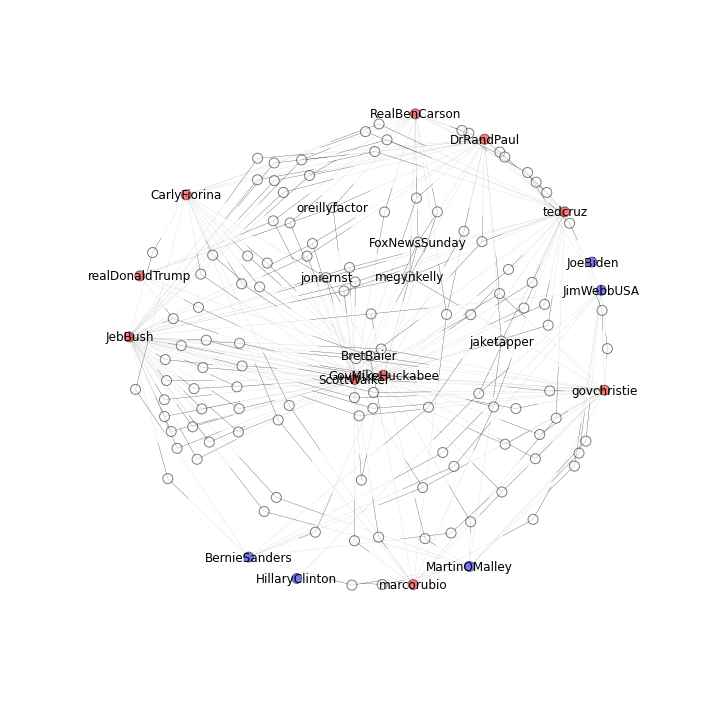

In [17]:
def get_color(name, republicans, democrats):
    if name in republicans:
        return 'r'
    elif name in democrats:
        return 'b'
    else:
        return 'w'

def draw_network(graph, republicans, democrats, candidate2friends, friend_counts):
    colors = [get_color(name, republicans, democrats) for name in graph.nodes()]
    labels = {n: n if n in candidate2friends or friend_counts[n] > 3 else '' for n in graph.nodes()}
    plt.figure(figsize=(12,12))
    nx.draw_networkx(graph, node_color=colors,
                     labels=labels, alpha=.5, width=.1,
                     node_size=100)
    plt.axis("off")
    plt.show()
    
draw_network(graph, republicans, democrats, candidate2friends, friend_counts)

In [18]:
# This will write some information to a text file, which we'll use to help grading.
# Be sure to run this code once at the end and check the resulting file (output.txt) into Github.
import json
outf = open('output.txt', 'wt')
json.dump({'candidates': sorted(candidates),
            'republicans': sorted(republicans),
            'democrats': sorted(democrats),
            'republican_counts': sorted(count_friends({k: v for k, v in candidate2friends.items() if k in republicans}).most_common(10)),
            'democrat_counts': sorted(count_friends({k: v for k, v in candidate2friends.items() if k in democrats}).most_common(10)),
            'num_nodes': len(graph.nodes()),
            'num_edges': len(graph.edges()),
            'republican_scores': sorted(republican_scores),
          }, outf, indent=2, sort_keys=True)
outf.close()

That's it for now! This should give you an introduction to some of the data we'll study in this course.